<a href="https://colab.research.google.com/github/AntonPrazdnichnykh/dul_2021/blob/hw1/Homework1_MADE_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 149 (delta 60), reused 119 (delta 42), pack-reused 0
Receiving objects: 100% (149/149), 27.59 MiB | 23.57 MiB/s, done.
Resolving deltas: 100% (60/60), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_20

In [2]:
from dul_2021.utils.hw1_utils import *

In [18]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import numpy as np
from sklearn.model_selection import train_test_split
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


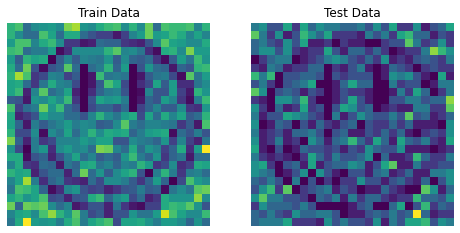

Dataset 2


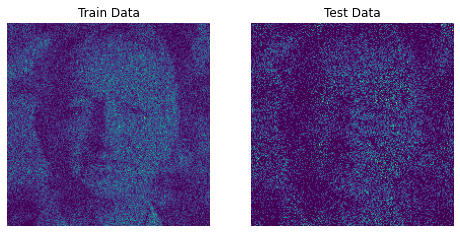

In [5]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

In [6]:
d1 = get_data_q1_a(dset_type=1)
d1

array([[24, 23],
       [15,  3],
       [12,  6],
       ...,
       [15, 12],
       [ 1, 13],
       [ 1,  4]])

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [7]:
class MaskedLinear(nn.Linear):
  def __init__(self, mask, in_features, out_features, bias=True):
    super().__init__(in_features, out_features, bias)
    self.register_buffer('mask', mask)

  def forward(self, x):
    # print(x.size(), self.mask.size(), self.weight.size())
    return F.linear(x, self.mask * self.weight, self.bias)


class MADE(nn.Module):
  def __init__(self, in_dim, out_dim, hidden_dims, masks):
    assert len(hidden_dims) + 1 == len(masks)
    super().__init__()
    dims = [in_dim] + hidden_dims + [out_dim]
    layers = []
    for i in range(len(dims) - 1):
      layers.extend([MaskedLinear(masks[i], dims[i], dims[i+1]), nn.ReLU()])
 
    self.net = nn.Sequential(*layers[:-1])

  def forward(self, x):
    return self.net(x)


In [8]:
def one_hot(data, d, device):
  sample_size = data.shape[0]
  encoded = torch.zeros((sample_size, 2 * d), device=device)
  idx = np.arange(sample_size)
  encoded[:, :d][idx, data[:, 0]] = 1
  encoded[:, d:][idx, data[:, 1]] = 1
  return encoded

In [9]:
CONFIGS = [
           {
            'n_epochs': 5,
            'batch_size': 1024,
            'lr': 0.01,
           },
           {
            'n_epochs': 2,
            'batch_size': 1024,
            'lr': 1e-3,
           }
]

In [10]:
def run_epoch(model, optimizer, data, device, d, batch_size, holdout='train'):
  assert holdout in ['train', 'test']
  n_steps = ceil(len(data) / batch_size)
  losses = []
  if holdout == 'train':
    data = np.random.permutation(data)
  for step in range(n_steps):
      batch = data[step * batch_size: (step + 1) * batch_size]
      batch_enc = one_hot(batch, d, device)
      if holdout == 'train':
        logits = model(batch_enc)
      else:
        with torch.no_grad():
          logits = model(batch_enc)
      logits = torch.stack((logits[:, :d], logits[:, d:]), dim=2)
      target = torch.tensor(np.stack((batch[:, 0], batch[:, 1]), axis=1), device=device)
      loss = F.cross_entropy(logits, target, reduction='sum') / batch.shape[0]

      losses.append(loss.item())

      if holdout == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  return losses

In [11]:
def predict_proba(model, d, device):
  data = np.zeros((d, 2), dtype=np.int32)
  data[:, 0] = np.arange(d)
  with torch.no_grad():
    pr = model(one_hot(data, d, device))
  p_x1, p_x2_x1 = F.softmax(pr[:, :d], dim=1), F.softmax(pr[:, d:], dim=1)
  ans = (p_x1.T * p_x2_x1).cpu().numpy()
  return ans

In [12]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    dset_id -= 1
    batch_size = CONFIGS[dset_id]['batch_size']
    hidden_dims = [3 * d, 3 * d]
    m01 = torch.zeros((3 * d, 2 * d), device=device)
    m01[:, :d] = 1
    m12 = torch.ones((3 * d, 3 * d), device=device)
    m23 = torch.zeros((2 * d, 3 * d), device=device)
    m23[d:, :] = 1
    model = MADE(2 * d, 2 * d, hidden_dims, [m01, m12, m23]).to(device)
    optimizer = Adam(model.parameters(), lr=CONFIGS[dset_id]['lr']) # Adam(model.parameters(), lr=CONFIG['lr'])
    train_losses = []
    test_losses = [np.mean(run_epoch(model, optimizer, test_data, device, d, batch_size, holdout='test'))]

    for epoch in range(CONFIGS[dset_id]['n_epochs']):
      train_losses.extend(run_epoch(model, optimizer, train_data, device, d, batch_size, holdout='train'))
      test_losses.append(np.mean(run_epoch(model, optimizer, test_data, device, d, batch_size, holdout='test')))

    probs = predict_proba(model, d, device)
    return np.array(train_losses), np.array(test_losses), probs


### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 6.3833


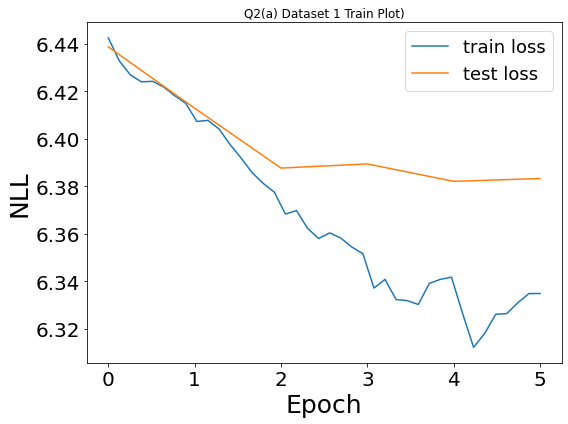

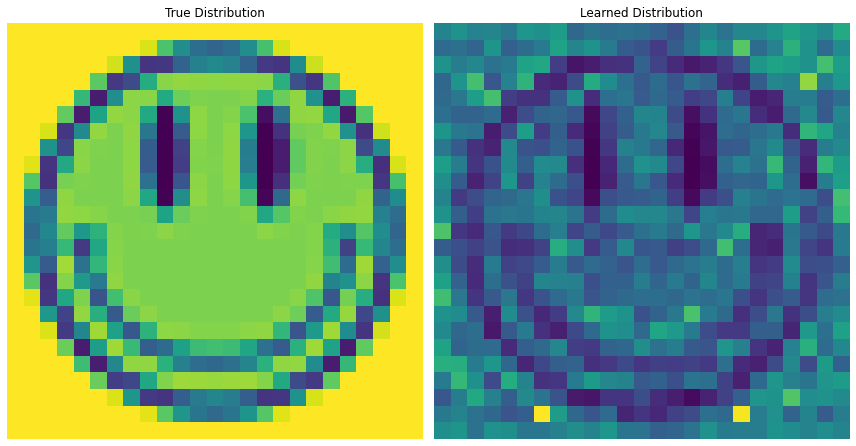

In [ ]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 10.6458


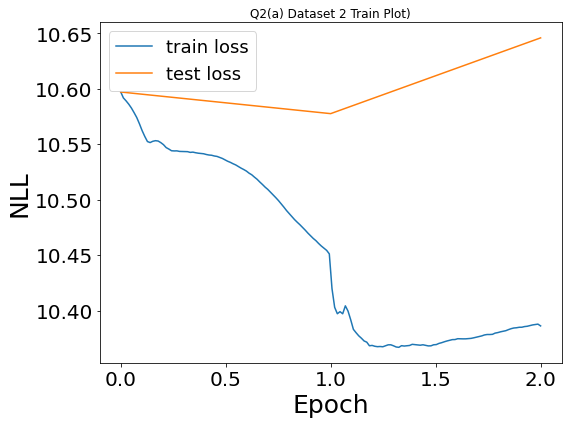

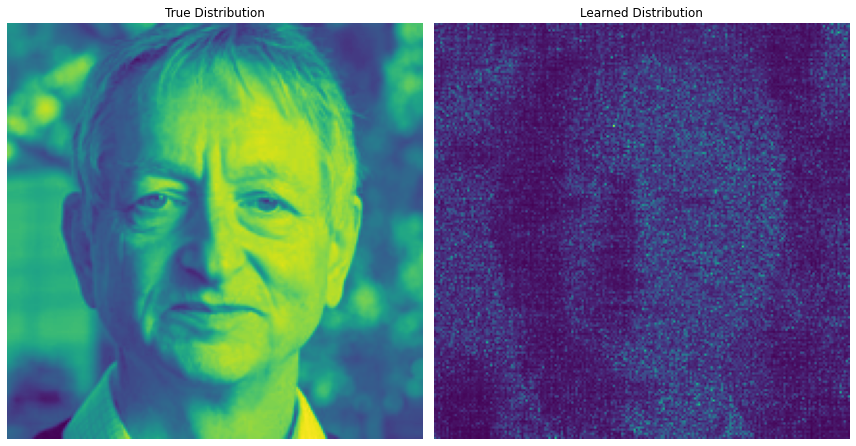

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

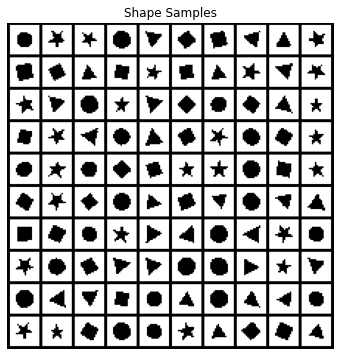

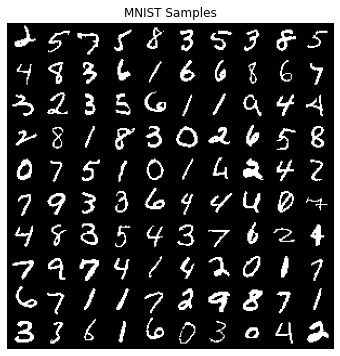

In [13]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

In [14]:
get_data_q1_b(dset_type=1).dtype

dtype('uint8')

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [15]:
def generate_masks(seq_dim, hidden_dims):
  d = torch.arange(seq_dim)
  masks = []
  prev_m = d
  for k in hidden_dims:
    m = torch.randint(prev_m.min(), seq_dim-1, (k, 1))
    masks.append((m >= prev_m).long())
    prev_m = m.view(-1)
  masks.append((d.view(-1, 1) > prev_m).long())
  return masks

In [16]:
masks = generate_masks(5, [10, 10])

In [17]:
m1, m2, m3 = masks
m3 @ m2 @ m1

tensor([[ 0,  0,  0,  0,  0],
        [ 3,  0,  0,  0,  0],
        [23, 15,  0,  0,  0],
        [30, 21,  3,  0,  0],
        [40, 30,  9,  3,  0]])

In [19]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    dset_id -= 1
    batch_size = CONFIGS[dset_id]['batch_size']
    h, w = image_shape
    d = h * w
    hidden_dims = [2 * d, 2 * d]
    masks = generate_masks(d, hidden_dims)
    model = MADE(d, d, hidden_dims, masks).to(device)
    optimizer = Adam(model.parameters(), lr=CONFIGS[dset_id]['lr'])
    train_losses = []
    test_losses = [np.mean(run_epoch_b(model, optimizer, test_data, device, batch_size, holdout='test'))]

    for epoch in tqdm(range(CONFIGS[dset_id]['n_epochs'])):
      train_losses.extend(run_epoch_b(model, optimizer, train_data, device, batch_size, holdout='train'))
      test_losses.append(np.mean(run_epoch_b(model, optimizer, test_data, device, batch_size, holdout='test')))

    sampled = sample_imgs(model, 100, h, w, device)
    return np.array(train_losses), np.array(test_losses), sampled


In [20]:
def run_epoch_b(model, optimizer, data, device, batch_size, holdout='train'):
  assert holdout in ['train', 'test']
  n_steps = ceil(len(data) / batch_size)
  losses = []
  if holdout == 'train':
    data = np.random.permutation(data)
  for step in range(n_steps):
      batch = torch.tensor(data[step * batch_size: (step + 1) * batch_size], dtype=torch.float32, device=device).flatten(start_dim=1)
      if holdout == 'train':
        logits = model(batch)
      else:
        with torch.no_grad():
          logits = model(batch)
      
      # print(torch.sigmoid(logits), batch, sep='\n')
      loss = F.binary_cross_entropy_with_logits(logits, batch, reduction='mean') #/ batch.shape[0]

      losses.append(loss.item())

      if holdout == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  return losses

In [21]:
def sample_imgs(model, n_samples, h, w, device):
  sampled = torch.zeros((n_samples, h * w)).to(device)
  for i in range(h * w):
    with torch.no_grad():
      pr = model(sampled)
    sampled[:, i] = (torch.rand(n_samples).to(device) <= pr[:, i]).float()
  return sampled.view(n_samples, h, w, 1).cpu().numpy().astype(np.uint8)

In [25]:
CONFIGS = [
           {
            'n_epochs': 100,
            'batch_size': 1024,
            'lr': 0.01,
           },
           {
            'n_epochs': 50,
            'batch_size': 1024,
            'lr': 0.01,
           }
]

In [ ]:
data = get_data_q1_b(dset_type=1)
train_data, test_data = train_test_split(data, train_size=0.8)
train_losses, test_losses, sampled = q1_b(train_data, test_data, (20, 20), dset_id=1)

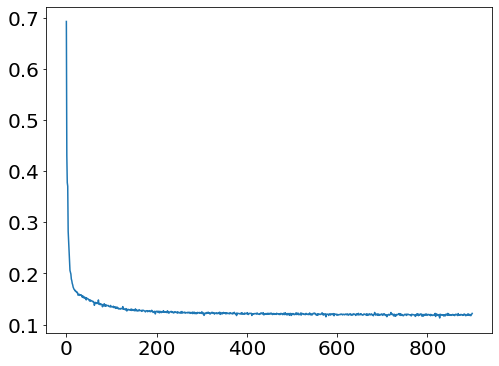

In [ ]:
plt.plot(train_losses)
plt.show()

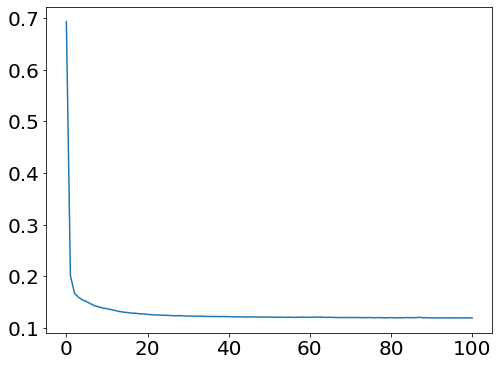

In [ ]:
plt.plot(test_losses)
plt.show()

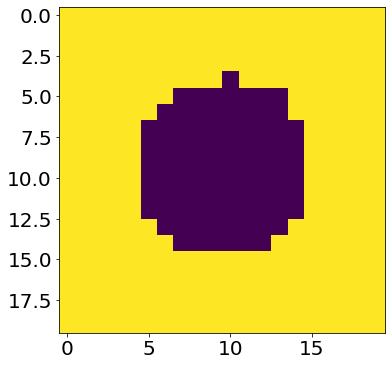

In [ ]:
plt.imshow(sampled[0].squeeze())

In [ ]:
data = get_data_q1_b(dset_type=2)
train_data, test_data = train_test_split(data, train_size=0.8)
train_losses, test_losses, sampled = q1_b(train_data, test_data, (28, 28), dset_id=2)

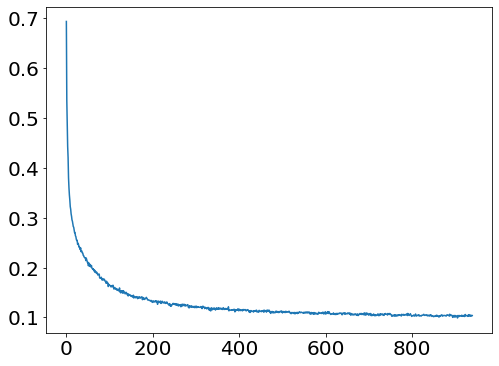

In [ ]:
plt.plot(train_losses)
plt.show()

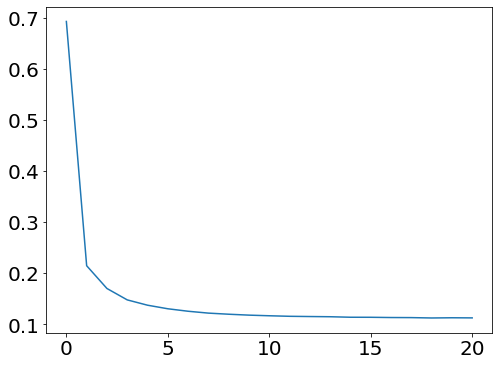

In [ ]:
plt.plot(test_losses)
plt.show()

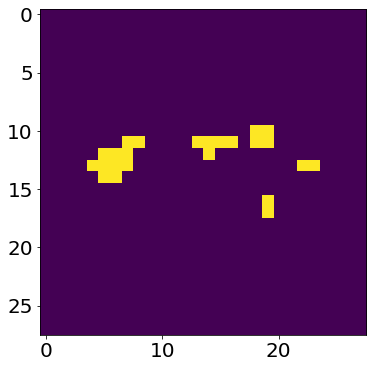

In [ ]:
plt.imshow(sampled[0].squeeze())

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



  0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 0.1092


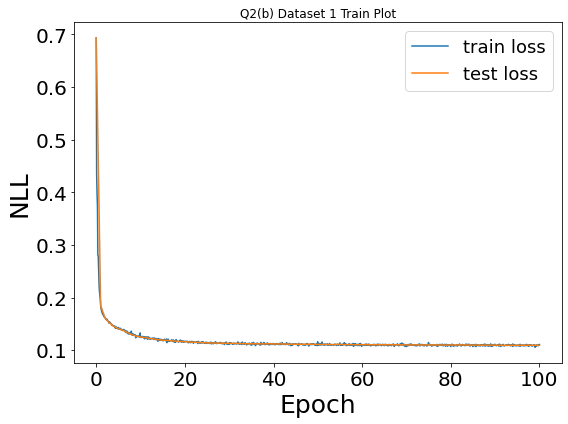

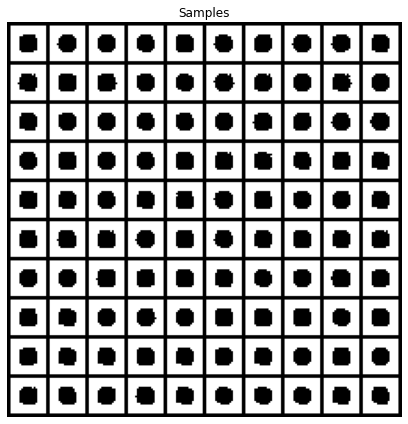

In [23]:
q1_save_results(1, 'b', q1_b)

  0%|          | 0/50 [00:00<?, ?it/s]

Final Test Loss: 0.1128


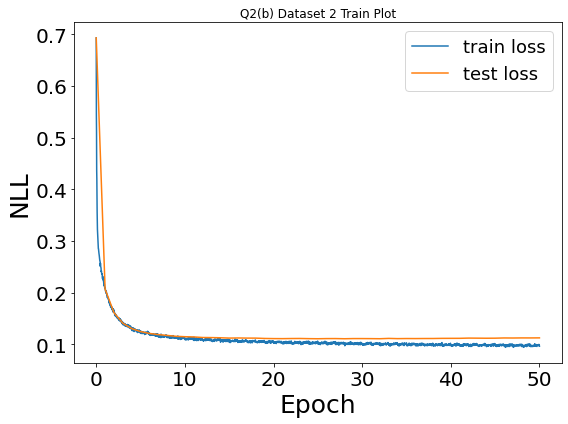

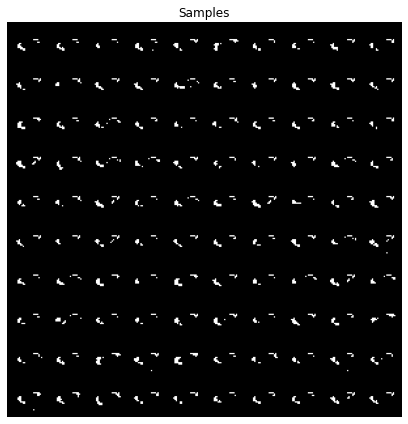

In [26]:
q1_save_results(2, 'b', q1_b)

что ж, с циферками что-то пошло не так, но возможно это вопрос подбора гиперпарамтров.